In this part we will fetch the data from https://api.nobelprize.org/2.1/nobelPrizes?nobelPrizeCategory=phy. We then extract the motivations and add it to one long string. Then we create the wordcloud .

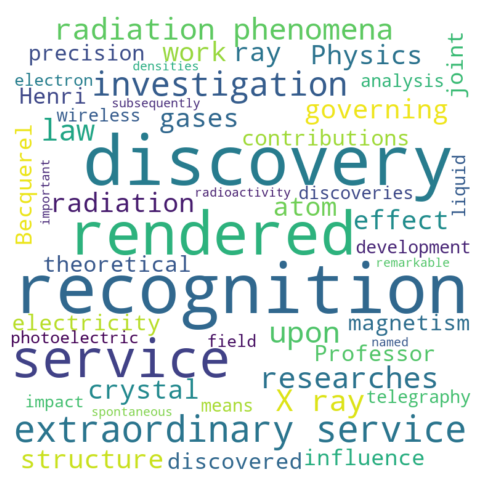

In [5]:
import requests
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#fetch data
url = "https://api.nobelprize.org/2.1/nobelPrizes?nobelPrizeCategory=phy"
response = requests.get(url)
data = response.json()

# extract motivations
motivations = []

for prize in data.get("nobelPrizes", []):
    if "laureates" in prize:
        for laureate in prize["laureates"]:
            motivation = laureate.get("motivation", {}).get("en", "")
            if motivation:
                motivations.append(motivation)


list = " ".join(motivations)

# code for setting up the wordcloud
wordcloud = WordCloud(width=750, height=750, 
                      background_color="white", 
                      max_words=50).generate(list)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


We will first create a functiom that scrapes book data between page numbers a and b. We create the apporpriate URL which is the page_num. It then collect the book title prices and ratings. Then for each book we take the title name and turn it into a string which is the corresponding url, and sends a request to fetch that page. For example a title: A Light in the Attic would become a-light-in-the-attic. This we have to do since the UPC is in the specific book page and hence why we need to collect the title name before so we can access each page. We will collcect the upc, title, price and rating. We then store all of the information in lists which we then make a table from. As we can see below not all request were successful, out of the 60 books we were only able to succesfuly gather 47 pages.

In [15]:
import requests
from bs4 import BeautifulSoup
import pandas as pd




 # fetches the base page and goings trough the page a to b
def scraper(a, b):
    base_url = "https://books.toscrape.com/"
    upcs, titles_all, prices_all, ratings_all = [], [], [], []
    book_index = 1  # Start book index at 1

    for page_num in range(a, b + 1):  
        page_url = f"{base_url}catalogue/page-{page_num}.html" if page_num > 1 else base_url
        response = requests.get(page_url)
        
        if response.status_code != 200:
            continue
        
        soup = BeautifulSoup(response.content, "html.parser")

        # extract titles, prices, and ratings
        titles = [a['title'] for a in soup.select(".product_pod h3 a")]
        prices = [price.get_text() for price in soup.select(".product_pod .price_color")]
        ratings = [rating["class"][1] for rating in soup.select(".product_pod p.star-rating")]



        # format specific book page and collect upc
        for i, title in enumerate(titles):
            title_url = ''.join(e for e in title.lower().replace(" ", "-") if e.isalnum() or e == '-')
            book_url = f"{base_url}catalogue/{title_url}_{1001 - book_index}/index.html"
            book_response = requests.get(book_url)
            
            if book_response.status_code != 200:
                continue
            
            book_soup = BeautifulSoup(book_response.content, "html.parser")
            upc = book_soup.select_one("table tr:nth-child(1) td").get_text(strip=True)

            upcs.append(upc)
            titles_all.append(title)
            prices_all.append(prices[i])
            ratings_all.append(ratings[i])
            book_index += 1



    
    books_df = pd.DataFrame({
        "UPC": upcs,
        "Title": titles_all,
        "Price": prices_all,
        "Rating": ratings_all
        })
    
    return books_df

books_df = scraper(1, 3)
books_df.head(60)


UPC                                              Title  \
0   a897fe39b1053632                               A Light in the Attic   
1   90fa61229261140a                                 Tipping the Velvet   
2   6957f44c3847a760                                         Soumission   
3   e00eb4fd7b871a48                                      Sharp Objects   
4   4165285e1663650f              Sapiens: A Brief History of Humankind   
5   f77dbf2323deb740                                    The Requiem Red   
6   2597b5a345f45e1b  The Dirty Little Secrets of Getting Your Dream...   
7   e72a5dfc7e9267b2  The Coming Woman: A Novel Based on the Life of...   
8   e10e1e165dc8be4a  The Boys in the Boat: Nine Americans and Their...   
9   1dfe412b8ac00530                                    The Black Maria   
10  0312262ecafa5a40     Starving Hearts (Triangular Trade Trilogy, #1)   
11  30a7f60cd76ca58c                              Shakespeare's Sonnets   
12  ce6396b0f23f6ecc                                        Set Me Free   
13  3b1c02bac2a429e6  Scott Pilgrim's Precious Little Life (Scott Pi...   
14  a34ba96d4081e6a4                          Rip it Up and Start Again   
15  deda3e61b9514b83  Our Band Could Be Your Life: Scenes from the A...   
16  feb7cc7701ecf901                                               Olio   
17  e30f54cea9b38190  Mesaerion: The Best Science Fiction Stories 18...   
18  a18a4f574854aced                       Libertarianism for Beginners   
19  a22124811bfa8350                            It's Only the Himalayas   
20  23356462d1320d61                                        In Her Wake   
21  327f68a59745c102                                    How Music Works   
22  5674a18a29a43ced  Foolproof Preserving: A Guide to Small Batch J...   
23  c2e46a2ee3b4a322                         Chase Me (Paris Nights #2)   
24  00bfed9e18bb36f3                                         Black Dust   
25  9528d0948525bf5f                      Birdsong: A Story in Pictures   
26  c7d160c2c0de586f  America's Cradle of Quarterbacks: Western Penn...   
27  904208d6aa64b655                     Aladdin and His Wonderful Lamp   
28  4c28def39d850cdf  Worlds Elsewhere: Journeys Around Shakespeare’...   
29  ccd9ffa25efabdea                                     Wall and Piece   
30  6258a1f6a6dcfe50  The Four Agreements: A Practical Guide to Pers...   
31  3c039985229453bf  The Five Love Languages: How to Express Heartf...   
32  5dada2b7be26bd03                                  The Elephant Tree   
33  9f6568e9c95f60b0                             The Bear and the Piano   
34  6be3beb0793a53e7                                     Sophie's World   
35  668fe56b17cfcd4f                                        Penny Maybe   
36  094b269567e1c300     Maude (1883-1993):She Grew Up with the country   
37  19ed25f4641d5efd                               In a Dark, Dark Wood   
38  be5cc846f45496fb                                Behind Closed Doors   
39  55f9da0c5eea2e10                     You can't bury them all: Poems   
40  b4fd5943413e089a                     Slow States of Collapse: Poems   
41  c8f7f0cb1abb9cac                              Reasons to Stay Alive   
42  b12b89017878a60d                        Private Paris (Private #10)   
43  c27f6e1f185b0383  #HigherSelfie: Wake Up Your Life. Free Your So...   
44  acddfeab2a407640                    Without Borders (Wanderlove #1)   
45  3ecb690d1542c568                                   When We Collided   
46  8d455c7539795d2a                       We Love You, Charlie Freeman   
47  657fe5ead67a7767            Untitled Collection: Sabbath Poems 2014   

     Price Rating  
0   £51.77  Three  
1   £53.74    One  
2   £50.10    One  
3   £47.82   Four  
4   £54.23   Five  
5   £22.65    One  
6   £33.34   Four  
7   £17.93  Three  
8   £22.60   Four  
9   £52.15    One  
10  £13.99    Two  
11  £20.66   Four  
12  £17.46   Five  
13  £52.29   Five  
14  £35.02   Five  
15  £57.25  Three  
1